<a href="https://colab.research.google.com/github/spenser-goff/CMSC320_Final/blob/main/Final_Project_Sea_Level.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicting Local Changes in Sea Level**
Sai Gopinath, Spenser Goff

# Introduction

Sea level is rising on a global scale due to thermal expansion and melting glaciers. While there is already much work done to predict rise in sea level worldwide, we want to predict local sea level changes on a smaller time scale. Predicting changes in sea level on the regional level is important because rise in sea level is a safety concern to those living close to the coast, can harm both land and sea ecosystems, and can destroy infrastructure. 

Our objective in this project is to analyze and predict changes in sea level by city based on regional factors such as consecutive dry days, precipitation, and frequency of low/high temperatures. 


### Glossary


*   Sealevel: the height of the water as measured along the coast relative to a specific point on land (Millimeters)
*   CDD: Consecutive dry days. The number of days with precipitation less than one millimeter (# of Days)
*   Rx5: Maximum consecutive 5-day precipitation amount in a month (Millimeters)
*   T10: Days in the month in which the low temperature is below the 10th percentile (%)
*   T90: Days in the month in which the high temperature is above the 90th percentile (%)
*  WP90: Days in the month in which the wind power is above the 90th percentile (%)


For more information about our features, check out the ACI's [about page](https://actuariesclimateindex.org/data/component-definitions/)
















### Required Tools
- pandas
- numpy
- seaborn
- matplotlib
- sklearn


In [ ]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn import linear_model


# Scraping The Data
Our dataset comes from the [Actuaries Climate Index](https://actuariesclimateindex.org/data/#) (ACI) is stored in an excel sheet. 

We will use colab's file package to import the excel worksheet.
Each sheet corresponding to our features of interest will need to be read into a dataframe and cleaned. Data cleaning is a necessary step for data analysis. Fortunately, our data comes from an excel file making it easier to process, as each sheet is formatted the exact same way. This is an advantage of using processed, structured data as opposed to scraping raw data from the web. To demonstrate our functions, we'll display the sealevel dataframe throughout the scraping and tidying process.

In [ ]:
from google.colab import files
#uploaded = files.upload()

In [ ]:
#Useful functions to process the data
def process_nulls(df):
  col_thresh = df.shape[0] * 0.5 #If a column has fewer than 50% of non-null values then drop
  row_thresh = df.shape[1] * 0.5 #If a row has fewer than 50% of non-null values then drop
  df = df.dropna(thresh=col_thresh, axis = 1) #Drops null columns
  df = df.dropna(thresh=row_thresh, axis = 0) #Drops null rows
  df = df.reset_index(drop=True) #Reset the index
  return(df) #Return dataframe


def process_rename(df):
  df.rename(columns={'Unnamed: 1':'Station'}, inplace=True) #First column renamed
  col_indice = 2 #Set column index
  for i in range(1961, 2022): #For years 1961 to 2021
    for j in range(1,13):   #For months 1 to 12
        col_name = (str(j) + "/" +str(i))   #Column name will be month / year
        unnamed_col = "Unnamed: " + str(col_indice)     #The current column name is Unnamed: _
        df.rename(columns={unnamed_col:col_name}, inplace=True) #Rename
        col_indice += 1     #Increment column index
  return(df) #Return dataframe

def process_smoothed(df, n):
  for k in range(n): #Drop the 'n' unsmoothed rows 
    df.drop(labels=k, axis=0, inplace=True) #Drop the row with label k
  df = df.reset_index(drop=True) #Reset index
  station_lst = df.Station.values  #Get the station abbreviation list
  df.set_index('Station', inplace=True) #Use the Station column as the names of the indices
  return(df, station_lst) #Return dataframe, station abbreviation list

def process_visualization(df, station_lst):
  for station in station_lst: #Plot each station's observed values over time
    df_tmp = df.loc[station] #Get the row for the station
    dates = df_tmp.index #Get the string date 
    obs = df_tmp.values  #Get whatever value we are plotting
    df_tmp = pd.DataFrame()
    df_tmp['Date'] = dates
    df_tmp['Observed'] = obs
    df_tmp['Date'] = pd.to_datetime(df_tmp['Date']) #Convert to daetime object
    _ = sns.lineplot(data=df_tmp, x='Date', y='Observed', legend="full") #Plot value over time
  plt.legend(labels=station_lst) #Use station abbreviations for legend
  plt.show()

def reshape_datecolumn(df, val_name): #val_name = sea level, rx5, etc.
  df_temp = df.reset_index()    #Reset the index
  
  #Store each station, date combo with the its observed value in a dataframe
  df_temp = df_temp.melt(id_vars = ["Station"], var_name = "Date", value_name= val_name) 
  df_temp['Date'] = pd.to_datetime(df_temp['Date']) #Convert to datetime object
  df_temp = df_temp[~(df_temp['Date'] < '2000-01-01')] #Only include date in the 21st century
  df_temp = df_temp.reset_index(drop=True) #Reset the index
  return df_temp

As defined above, the features we will be exploring are
sealevel, CDD, Rx5, T10, T90, and WP90. We read in the sheet for each variable listed by month over time.
Each dataframe is then cleared of any row or column with less than
50 percent non-null values.

In [ ]:
df_2 = pd.read_excel("sealevel.xlsx", sheet_name=2) #Sealevel Monthly
df_2 = process_nulls(df_2)
display(df_2.head(5))

df_5 = pd.read_excel("sealevel.xlsx", sheet_name=5) #CDD Monthly
df_5 = process_nulls(df_5)

df_8 = pd.read_excel("sealevel.xlsx", sheet_name=8) #Rx5 Monthly
df_8 = process_nulls(df_8)

df_11 = pd.read_excel("sealevel.xlsx", sheet_name=11) #T10 monthly
df_11 = process_nulls(df_11)

df_14 = pd.read_excel("sealevel.xlsx", sheet_name=14) #T90 monthly
df_14 = process_nulls(df_14)

df_17 = pd.read_excel("sealevel.xlsx", sheet_name=17) #WP90 Monthly
df_17 = process_nulls(df_17)


,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54,Unnamed: 55,Unnamed: 56,Unnamed: 57,Unnamed: 58,Unnamed: 59,Unnamed: 60,Unnamed: 61,Unnamed: 62,Unnamed: 63,Unnamed: 64,Unnamed: 65,Unnamed: 66,Unnamed: 67,Unnamed: 68,Unnamed: 69,Unnamed: 70,Unnamed: 71,Unnamed: 72,Unnamed: 73,Unnamed: 74,Unnamed: 75,Unnamed: 76,Unnamed: 77,Unnamed: 78,Unnamed: 79,Unnamed: 80,Unnamed: 81,Unnamed: 82,Unnamed: 83,Unnamed: 84,Unnamed: 85,Unnamed: 86,Unnamed: 87,Unnamed: 88,Unnamed: 89,Unnamed: 90,Unnamed: 91,Unnamed: 92,Unnamed: 93,Unnamed: 94,Unnamed: 95,Unnamed: 96,Unnamed: 97,Unnamed: 98,Unnamed: 99,Unnamed: 100,Unnamed: 101,Unnamed: 102,Unnamed: 103,Unnamed: 104,Unnamed: 105,Unnamed: 106,Unnamed: 107,Unnamed: 108,Unnamed: 109,Unnamed: 110,Unnamed: 111,Unnamed: 112,Unnamed: 113,Unnamed: 114,Unnamed: 115,Unnamed: 116,Unnamed: 117,Unnamed: 118,Unnamed: 119,Unnamed: 120,Unnamed: 121,Unnamed: 122,Unnamed: 123,Unnamed: 124,Unnamed: 125,Unnamed: 126,Unnamed: 127,Unnamed: 128,Unnamed: 129,Unnamed: 130,Unnamed: 131,Unnamed: 132,Unnamed: 133,Unnamed: 134,Unnamed: 135,Unnamed: 136,Unnamed: 137,Unnamed: 138,Unnamed: 139,Unnamed: 140,Unnamed: 141,Unnamed: 142,Unnamed: 143,Unnamed: 144,Unnamed: 145,Unnamed: 146,Unnamed: 147,Unnamed: 148,Unnamed: 149,Unnamed: 150,Unnamed: 151,Unnamed: 152,Unnamed: 153,Unnamed: 154,Unnamed: 155,Unnamed: 156,Unnamed: 157,Unnamed: 158,Unnamed: 159,Unnamed: 160,Unnamed: 161,Unnamed: 162,Unnamed: 163,Unnamed: 164,Unnamed: 165,Unnamed: 166,Unnamed: 167,Unnamed: 168,Unnamed: 169,Unnamed: 170,Unnamed: 171,Unnamed: 172,Unnamed: 173,Unnamed: 174,Unnamed: 175,Unnamed: 176,Unnamed: 177,Unnamed: 178,Unnamed: 179,Unnamed: 180,Unnamed: 181,Unnamed: 182,Unnamed: 183,Unnamed: 184,Unnamed: 185,Unnamed: 186,Unnamed: 187,Unnamed: 188,Unnamed: 189,Unnamed: 190,Unnamed: 191,Unnamed: 192,Unnamed: 193,Unnamed: 194,Unnamed: 195,Unnamed: 196,Unnamed: 197,Unnamed: 198,Unnamed: 199,Unnamed: 200,Unnamed: 201,Unnamed: 202,Unnamed: 203,Unnamed: 204,Unnamed: 205,Unnamed: 206,Unnamed: 207,Unnamed: 208,Unnamed: 209,Unnamed: 210,Unnamed: 211,Unnamed: 212,Unnamed: 213,Unnamed: 214,Unnamed: 215,Unnamed: 216,Unnamed: 217,Unnamed: 218,Unnamed: 219,Unnamed: 220,Unnamed: 221,Unnamed: 222,Unnamed: 223,Unnamed: 224,Unnamed: 225,Unnamed: 226,Unnamed: 227,Unnamed: 228,Unnamed: 229,Unnamed: 230,Unnamed: 231,Unnamed: 232,Unnamed: 233,Unnamed: 234,Unnamed: 235,Unnamed: 236,Unnamed: 237,Unnamed: 238,Unnamed: 239,Unnamed: 240,Unnamed: 241,Unnamed: 242,Unnamed: 243,Unnamed: 244,Unnamed: 245,Unnamed: 246,Unnamed: 247,Unnamed: 248,Unnamed: 249,Unnamed: 250,Unnamed: 251,Unnamed: 252,Unnamed: 253,Unnamed: 254,Unnamed: 255,Unnamed: 256,Unnamed: 257,Unnamed: 258,Unnamed: 259,Unnamed: 260,Unnamed: 261,Unnamed: 262,Unnamed: 263,Unnamed: 264,Unnamed: 265,Unnamed: 266,Unnamed: 267,Unnamed: 268,Unnamed: 269,Unnamed: 270,Unnamed: 271,Unnamed: 272,Unnamed: 273,Unnamed: 274,Unnamed: 275,Unnamed: 276,Unnamed: 277,Unnamed: 278,Unnamed: 279,Unnamed: 280,Unnamed: 281,Unnamed: 282,Unnamed: 283,Unnamed: 284,Unnamed: 285,Unnamed: 286,Unnamed: 287,Unnamed: 288,Unnamed: 289,Unnamed: 290,Unnamed: 291,Unnamed: 292,Unnamed: 293,Unnamed: 294,Unnamed: 295,Unnamed: 296,Unnamed: 297,Unnamed: 298,Unnamed: 299,Unnamed: 300,Unnamed: 301,Unnamed: 302,Unnamed: 303,Unnamed: 304,Unnamed: 305,Unnamed: 306,Unnamed: 307,Unnamed: 308,Unnamed: 309,Unnamed: 310,Unnamed: 311,Unnamed: 312,Unnamed: 313,Unnamed: 314,Unnamed: 315,Unnamed: 316

Then, we title every column with its corresponding month and year.

In [ ]:
df_2 = process_rename(df_2)
display(df_2.head(5))

df_5 = process_rename(df_5)

df_8 = process_rename(df_8)

df_11 = process_rename(df_11)

df_14 = process_rename(df_14)

df_17 = process_rename(df_17)

,Station,1/1961,2/1961,3/1961,4/1961,5/1961,6/1961,7/1961,8/1961,9/1961,10/1961,11/1961,12/1961,1/1962,2/1962,3/1962,4/1962,5/1962,6/1962,7/1962,8/1962,9/1962,10/1962,11/1962,12/1962,1/1963,2/1963,3/1963,4/1963,5/1963,6/1963,7/1963,8/1963,9/1963,10/1963,11/1963,12/1963,1/1964,2/1964,3/1964,4/1964,5/1964,6/1964,7/1964,8/1964,9/1964,10/1964,11/1964,12/1964,1/1965,2/1965,3/1965,4/1965,5/1965,6/1965,7/1965,8/1965,9/1965,10/1965,11/1965,12/1965,1/1966,2/1966,3/1966,4/1966,5/1966,6/1966,7/1966,8/1966,9/1966,10/1966,11/1966,12/1966,1/1967,2/1967,3/1967,4/1967,5/1967,6/1967,7/1967,8/1967,9/1967,10/1967,11/1967,12/1967,1/1968,2/1968,3/1968,4/1968,5/1968,6/1968,7/1968,8/1968,9/1968,10/1968,11/1968,12/1968,1/1969,2/1969,3/1969,4/1969,5/1969,6/1969,7/1969,8/1969,9/1969,10/1969,11/1969,12/1969,1/1970,2/1970,3/1970,4/1970,5/1970,6/1970,7/1970,8/1970,9/1970,10/1970,11/1970,12/1970,1/1971,2/1971,3/1971,4/1971,5/1971,6/1971,7/1971,8/1971,9/1971,10/1971,11/1971,12/1971,1/1972,2/1972,3/1972,4/1972,5/1972,6/1972,7/1972,8/1972,9/1972,10/1972,11/1972,12/1972,1/1973,2/1973,3/1973,4/1973,5/1973,6/1973,7/1973,8/1973,9/1973,10/1973,11/1973,12/1973,1/1974,2/1974,3/1974,4/1974,5/1974,6/1974,7/1974,8/1974,9/1974,10/1974,11/1974,12/1974,1/1975,2/1975,3/1975,4/1975,5/1975,6/1975,7/1975,8/1975,9/1975,10/1975,11/1975,12/1975,1/1976,2/1976,3/1976,4/1976,5/1976,6/1976,7/1976,8/1976,9/1976,10/1976,11/1976,12/1976,1/1977,2/1977,3/1977,4/1977,5/1977,6/1977,7/1977,8/1977,9/1977,10/1977,11/1977,12/1977,1/1978,2/1978,3/1978,4/1978,5/1978,6/1978,7/1978,8/1978,9/1978,10/1978,11/1978,12/1978,1/1979,2/1979,3/1979,4/1979,5/1979,6/1979,7/1979,8/1979,9/1979,10/1979,11/1979,12/1979,1/1980,2/1980,3/1980,4/1980,5/1980,6/1980,7/1980,8/1980,9/1980,10/1980,11/1980,12/1980,1/1981,2/1981,3/1981,4/1981,5/1981,6/1981,7/1981,8/1981,9/1981,10/1981,11/1981,12/1981,1/1982,2/1982,3/1982,4/1982,5/1982,6/1982,7/1982,8/1982,9/1982,10/1982,11/1982,12/1982,1/1983,2/1983,3/1983,4/1983,5/1983,6/1983,7/1983,8/1983,9/1983,10/1983,11/1983,12/1983,1/1984,2/1984,3/1984,4/1984,5/1984,6/1984,7/1984,8/1984,9/1984,10/1984,11/1984,12/1984,1/1985,2/1985,3/1985,4/1985,5/1985,6/1985,7/1985,8/1985,9/1985,10/1985,11/1985,12/1985,1/1986,2/1986,3/1986,4/1986,5/1986,6/1986,7/1986,8/1986,9/1986,10/1986,11/1986,12/1986,1/1987,2/1987,3/1987,4/1987,5/1987,6/1987,7/1987,8/1987,9/1987,10/1987,11/1987,12/1987,1/1988,2/1988,3/1988,4/1988,5/1988,6/1988,7/1988,8/1988,9/1988,10/1988,11/1988,12/1988,1/1989,2/1989,3/1989,4/1989,5/1989,6/1989,7/1989,8/1989,9/1989,10/1989,11/1989,12/1989,1/1990,2/1990,3/1990,4/1990,5/1990,6/1990,7/1990,8/1990,9/1990,10/1990,11/1990,12/1990,1/1991,2/1991,3/1991,4/1991,5/1991,6/1991,7/1991,8/1991,9/1991,10/1991,11/1991,12/1991,1/1992,2/1992,3/1992,4/1992,5/1992,6/1992,7/1992,8/1992,9/1992,10/1992,11/1992,12/1992,1/1993,2/1993,3/1993,4/1993,5/1993,6/1993,7/1993,8/1993,9/1993,10/1993,11/1993,12/1993,1/1994,2/1994,3/1994,4/1994,5/1994,6/1994,7/1994,8/1994,9/1994,10/1994,11/1994,12/1994,1/1995,2/1995,3/1995,4/1995,5/1995,6/1995,7/1995,8/1995,9/1995,10/1995,11/1995,12/1995,1/1996,2/1996,3/1996,4/1996,5/1996,6/1996,7/1996,8/1996,9/1996,10/1996,11/1996,12/1996,1/1997,2/1997,3/1997,4/1997,5/1997,6/1997,7/1997,8/1997,9/1997,10/1997,11/1997,12/1997,1/1998,2/1998,3/1998,4/1998,5/1998,6/1998,7/1998,8/1998,9/1998,10/1998,11/1998,12/1998,1/1999,2/1999,3/1999,4/1999,5/1999,6/1999,7/1999,8/1999,9/1999,10/1999,11/1999,12/1999,1/2000,2/2000,3/2000,4/2000,5/2000,6/2000,7/2000,8/2000,9/2000,10/2000,11/2000,12/2000,1/2001,2/2001,3/2001,4/2001,5/2001,6/2001,7/2001,8/2001,9/2001,10/2001,11/2001,12/2001,1/2002,2/2002,3/2002,4/2002,5/2002,6/2002,7/2002,8/2002,9/2002,10/2002,11/2002,12/2002,1/2003,2/2003,3/2003,4/2003,5/2003,6/2003,7/2003,8/2003,9/2003,10/2003,11/2003,12/2003,1/2004,2/2004,3/2004,4/2004,5/2004,6/2004,7/2004,8/2004,9/2004,10/2004,11/2004,12/2004,1/2005,2/2005,3/2005,4/2005,5/2005,6/2005,7/2005,8/2005,9/2005,10/2005,11/2005,12/2005,1/2006,2/2006,3/2006,4/2006,5/2006,6/2006,7/2006,8/2006,9/2006,10/2006,11/20

# Data Processing and Tidying


Each sheet contains the unsmoothed and smoothed values for each
station listed. We will limit our analysis to the smoothed data
and will drop the unneeded values from our dataframes. Additionally,
we will use the station abbreviations as indices of the columns.

In [ ]:
df_2, station_lst_2 = process_smoothed(df_2, 15)
print(station_lst_2)
display(df_2.head(5))

df_5, station_lst_5 = process_smoothed(df_5, 16)

df_8, station_lst_8 = process_smoothed(df_8, 17)

df_11, station_lst_11 = process_smoothed(df_11, 17)

df_14, station_lst_14 = process_smoothed(df_14, 17)

df_17, station_lst_17 = process_smoothed(df_17, 17)

['ALA' 'CEA' 'CWP' 'NEA' 'NEF' 'NPL' 'NWP' 'SEA' 'SPL' 'SWP' 'CAN' 'USA'
 'USC']


,1/1961,2/1961,3/1961,4/1961,5/1961,6/1961,7/1961,8/1961,9/1961,10/1961,11/1961,12/1961,1/1962,2/1962,3/1962,4/1962,5/1962,6/1962,7/1962,8/1962,9/1962,10/1962,11/1962,12/1962,1/1963,2/1963,3/1963,4/1963,5/1963,6/1963,7/1963,8/1963,9/1963,10/1963,11/1963,12/1963,1/1964,2/1964,3/1964,4/1964,5/1964,6/1964,7/1964,8/1964,9/1964,10/1964,11/1964,12/1964,1/1965,2/1965,3/1965,4/1965,5/1965,6/1965,7/1965,8/1965,9/1965,10/1965,11/1965,12/1965,1/1966,2/1966,3/1966,4/1966,5/1966,6/1966,7/1966,8/1966,9/1966,10/1966,11/1966,12/1966,1/1967,2/1967,3/1967,4/1967,5/1967,6/1967,7/1967,8/1967,9/1967,10/1967,11/1967,12/1967,1/1968,2/1968,3/1968,4/1968,5/1968,6/1968,7/1968,8/1968,9/1968,10/1968,11/1968,12/1968,1/1969,2/1969,3/1969,4/1969,5/1969,6/1969,7/1969,8/1969,9/1969,10/1969,11/1969,12/1969,1/1970,2/1970,3/1970,4/1970,5/1970,6/1970,7/1970,8/1970,9/1970,10/1970,11/1970,12/1970,1/1971,2/1971,3/1971,4/1971,5/1971,6/1971,7/1971,8/1971,9/1971,10/1971,11/1971,12/1971,1/1972,2/1972,3/1972,4/1972,5/1972,6/1972,7/1972,8/1972,9/1972,10/1972,11/1972,12/1972,1/1973,2/1973,3/1973,4/1973,5/1973,6/1973,7/1973,8/1973,9/1973,10/1973,11/1973,12/1973,1/1974,2/1974,3/1974,4/1974,5/1974,6/1974,7/1974,8/1974,9/1974,10/1974,11/1974,12/1974,1/1975,2/1975,3/1975,4/1975,5/1975,6/1975,7/1975,8/1975,9/1975,10/1975,11/1975,12/1975,1/1976,2/1976,3/1976,4/1976,5/1976,6/1976,7/1976,8/1976,9/1976,10/1976,11/1976,12/1976,1/1977,2/1977,3/1977,4/1977,5/1977,6/1977,7/1977,8/1977,9/1977,10/1977,11/1977,12/1977,1/1978,2/1978,3/1978,4/1978,5/1978,6/1978,7/1978,8/1978,9/1978,10/1978,11/1978,12/1978,1/1979,2/1979,3/1979,4/1979,5/1979,6/1979,7/1979,8/1979,9/1979,10/1979,11/1979,12/1979,1/1980,2/1980,3/1980,4/1980,5/1980,6/1980,7/1980,8/1980,9/1980,10/1980,11/1980,12/1980,1/1981,2/1981,3/1981,4/1981,5/1981,6/1981,7/1981,8/1981,9/1981,10/1981,11/1981,12/1981,1/1982,2/1982,3/1982,4/1982,5/1982,6/1982,7/1982,8/1982,9/1982,10/1982,11/1982,12/1982,1/1983,2/1983,3/1983,4/1983,5/1983,6/1983,7/1983,8/1983,9/1983,10/1983,11/1983,12/1983,1/1984,2/1984,3/1984,4/1984,5/1984,6/1984,7/1984,8/1984,9/1984,10/1984,11/1984,12/1984,1/1985,2/1985,3/1985,4/1985,5/1985,6/1985,7/1985,8/1985,9/1985,10/1985,11/1985,12/1985,1/1986,2/1986,3/1986,4/1986,5/1986,6/1986,7/1986,8/1986,9/1986,10/1986,11/1986,12/1986,1/1987,2/1987,3/1987,4/1987,5/1987,6/1987,7/1987,8/1987,9/1987,10/1987,11/1987,12/1987,1/1988,2/1988,3/1988,4/1988,5/1988,6/1988,7/1988,8/1988,9/1988,10/1988,11/1988,12/1988,1/1989,2/1989,3/1989,4/1989,5/1989,6/1989,7/1989,8/1989,9/1989,10/1989,11/1989,12/1989,1/1990,2/1990,3/1990,4/1990,5/1990,6/1990,7/1990,8/1990,9/1990,10/1990,11/1990,12/1990,1/1991,2/1991,3/1991,4/1991,5/1991,6/1991,7/1991,8/1991,9/1991,10/1991,11/1991,12/1991,1/1992,2/1992,3/1992,4/1992,5/1992,6/1992,7/1992,8/1992,9/1992,10/1992,11/1992,12/1992,1/1993,2/1993,3/1993,4/1993,5/1993,6/1993,7/1993,8/1993,9/1993,10/1993,11/1993,12/1993,1/1994,2/1994,3/1994,4/1994,5/1994,6/1994,7/1994,8/1994,9/1994,10/1994,11/1994,12/1994,1/1995,2/1995,3/1995,4/1995,5/1995,6/1995,7/1995,8/1995,9/1995,10/1995,11/1995,12/1995,1/1996,2/1996,3/1996,4/1996,5/1996,6/1996,7/1996,8/1996,9/1996,10/1996,11/1996,12/1996,1/1997,2/1997,3/1997,4/1997,5/1997,6/1997,7/1997,8/1997,9/1997,10/1997,11/1997,12/1997,1/1998,2/1998,3/1998,4/1998,5/1998,6/1998,7/1998,8/1998,9/1998,10/1998,11/1998,12/1998,1/1999,2/1999,3/1999,4/1999,5/1999,6/1999,7/1999,8/1999,9/1999,10/1999,11/1999,12/1999,1/2000,2/2000,3/2000,4/2000,5/2000,6/2000,7/2000,8/2000,9/2000,10/2000,11/2000,12/2000,1/2001,2/2001,3/2001,4/2001,5/2001,6/2001,7/2001,8/2001,9/2001,10/2001,11/2001,12/2001,1/2002,2/2002,3/2002,4/2002,5/2002,6/2002,7/2002,8/2002,9/2002,10/2002,11/2002,12/2002,1/2003,2/2003,3/2003,4/2003,5/2003,6/2003,7/2003,8/2003,9/2003,10/2003,11/2003,12/2003,1/2004,2/2004,3/2004,4/2004,5/2004,6/2004,7/2004,8/2004,9/2004,10/2004,11/2004,12/2004,1/2005,2/2005,3/2005,4/2005,5/2005,6/2005,7/2005,8/2005,9/2005,10/2005,11/2005,12/2005,1/2006,2/2006,3/2006,4/2006,5/2006,6/2006,7/2006,8/2006,9/2006,10/2006,11/2006,12/20

In order to run our machine learning algorithms, all dataframes need to be consolidated into a single table. To do this, we have to reshape each table such that date values are stored in a single column as opposed to rows. This increases the total size of our data, so we dropped data from before 2000 in order to keep a reasonable size for the final dataset. Then, we merge each modified dataframe using inner join in order to implicitly drop any missing values. 

In [ ]:
df_2mod = reshape_datecolumn(df_2, "Sea Level")
display(df_2mod.head(5))

df_5mod = reshape_datecolumn(df_5, "CDD")
df_8mod = reshape_datecolumn(df_8, "Rx5")
df_11mod = reshape_datecolumn(df_11, "T10")
df_14mod = reshape_datecolumn(df_14, "T90")
df_17mod = reshape_datecolumn(df_17, "WP90")

#Merging all data sets into all_data, using inner join to not deal w missing vals
all_data = df_2mod.merge(df_5mod, on=['Station', 'Date'])
all_data = all_data.merge(df_8mod , on=['Station', 'Date'])
all_data = all_data.merge(df_11mod , on=['Station', 'Date'])
all_data = all_data.merge(df_14mod , on=['Station', 'Date'])
all_data = all_data.merge(df_17mod , on=['Station', 'Date'])
display(all_data.head(5))

,Station,Date,Sea Level
0,ALA,2000-01-01,-1.94
1,CEA,2000-01-01,2.01
2,CWP,2000-01-01,0.68
3,NEA,2000-01-01,1.60
4,NEF,2000-01-01,0.01


,Station,Date,Sea Level,CDD,Rx5,T10,T90,WP90
0,ALA,2000-01-01,-1.94,1.02,-0.06,-0.41,0.30,-0.27
1,CEA,2000-01-01,2.01,-0.07,0.06,-0.48,0.19,0.00
2,CWP,2000-01-01,0.68,-0.91,0.75,-0.31,0.33,0.13
3,NEA,2000-01-01,1.60,-0.91,-0.06,-0.60,0.45,-0.08
4,NEF,2000-01-01,0.01,-0.08,0.29,-0.49,0.29,0.03


# Exploratory data analysis

### Visualizing Trends Over Time

First, we want to look at general trends over time for all variables involved. We use simple line graphs to acheive this. Once we have our graphs we can start to intuit which variables may be related. 

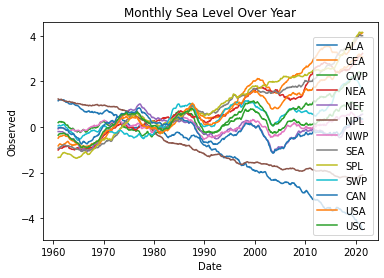

In [ ]:
plt.title("Monthly Sea Level Over Year")
process_visualization(df_2, station_lst_2)

As we can expect, sea level in general has been rising across stations. However, there is huge variability when we look at just a couple years at a time. This is what we wish to predict. Additionally, there are a few outliers such as CAN and NPL which are steadily decreasing across time and don't show much variability. 

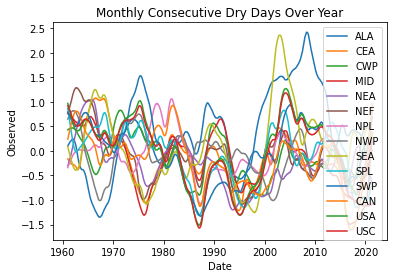

In [ ]:
plt.title("Monthly Consecutive Dry Days Over Year")
process_visualization(df_5, station_lst_5)

There aren't any strong trends immediately apparent from this graph. However, based on intuition, it is possible that proportion of dry days would be inversely correlated with sea level rise. This remains to be revealed with correlation analysis. 

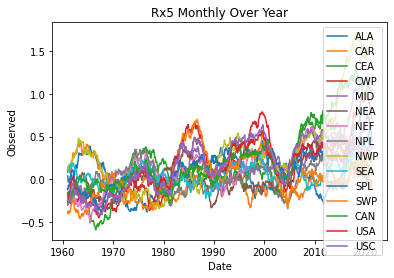

In [ ]:
plt.title("Rx5 Monthly Over Year")
process_visualization(df_8, station_lst_8)

As with CDD, there aren't any apparent trends. We can also try to intuit that Rx5, monthly maximum 5-day precipitation, would be correlated with a rise in sea level. 

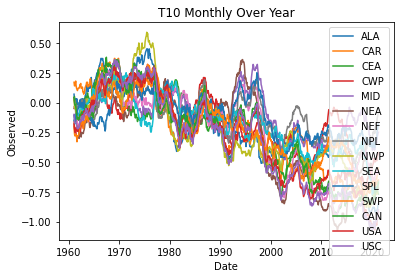

In [ ]:
plt.title("T10 Monthly Over Year")
process_visualization(df_11, station_lst_11)

We can see from the graph that T10, which corresponds to low temperatures, has been decreasing over time for all stations which large variability between years. Its possible that low temperatures are inversely correlated with rise in sea level. 

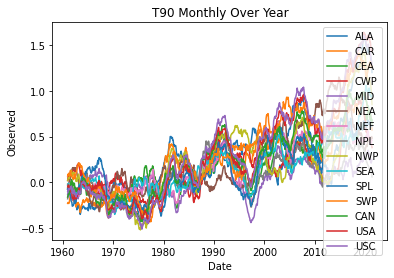

In [ ]:
plt.title("T90 Monthly Over Year")
process_visualization(df_14, station_lst_14)

T90, which corresponds to high temperatures, has been increasing over time largely due to global warming. Globally, high temperatures are correlated with rise in sea level, however it is hard to say if that holds true on a station by station basis.

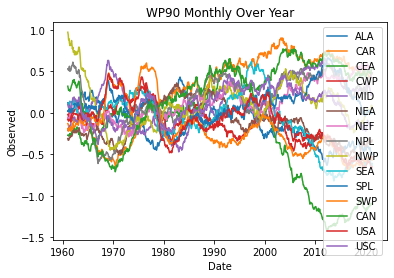

In [ ]:
plt.title("WP90 Monthly Over Year")
process_visualization(df_17, station_lst_17)

Wind power doesn't have many apparent trends but it seems that it has been decreasing in the past 10-15 years for most stations. Its hard to predict a relationship with sea level from intuition or from the data. 

### Correlational Heat Map
From the line plots we have gleaned some information about individual variables in terms of large trends over time and how much they vary from month to month. However, without correlational analysis we could only guess at which factors are related to sea level. We will use seaborne's correlational heatmap function to get values for correlations between variables and visualize how strongly they are related. 

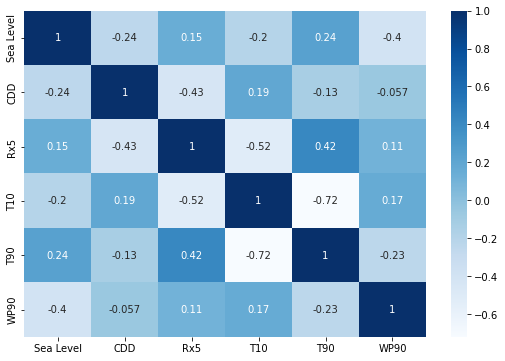

In [ ]:
plt.figure(figsize=(9,6))
sns.heatmap(all_data.corr(), annot=True, cmap='Blues')
plt.show()

From the correlational heat map we can identify which factors strongly influence others. For example, we can tell that T90 and T10 are strongly inversely correlated from the -.72 correlation score. This is unsuprising, as a month with many high temperatures days is unlikely to also contain many low temperature days. 

Looking specifically at sea level, we can see the correlational values of -.24, .15, -.2, .24, -.4 for CDD, Rx5, T10, T90, and WP90 respectively. Interestingly, Sea level is the most strongly (inversely) correlated with wind power. We can also see that it is positively correlated with precipitation and high temperatures, and negatively correlated with dry days and low temperatures. We were able to intuit this may be the case earlier, but now we can confirm our suspicions and see how high these correlations are. 

# Prediction - ML Algorithm

Now to actually try to predict sea level given the factors we have. We will use two different machine learning algorithms so that we can compare the results. 

Before running our algorithms, we first need to split our data into training and testing sets. We don't want to be testing the results of our prediction on the same data we predict on in order to prevent overfitting and get more accurate scores. 

In [ ]:
X = all_data.drop('Sea Level', axis=1)
Y = all_data['Sea Level']
#changing categorical variables Date and Station to dummies
X = pd.get_dummies(X, drop_first=True)
pd.set_option('display.max_columns', None)


X['Date'] = X['Date'].apply(lambda x: int(x.strftime('%Y%m%d')))
#print(X.head())

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 13)

display(x_train.head(5))


,Date,CDD,Rx5,T10,T90,WP90,Station_CAN,Station_CEA,Station_CWP,Station_NEA,Station_NEF,Station_NPL,Station_NWP,Station_SEA,Station_SPL,Station_SWP,Station_USA,Station_USC
1757,20110401,-0.30,0.27,-0.16,0.14,-0.24,0,0,1,0,0,0,0,0,0,0,0,0
280,20011001,1.58,-0.01,-0.25,0.33,0.10,0,0,0,0,0,0,0,1,0,0,0,0
378,20020601,0.38,-0.12,-0.59,0.44,-0.35,0,1,0,0,0,0,0,0,0,0,0,0
1424,20090201,0.61,-0.11,-0.44,0.33,-0.37,0,0,0,0,0,0,0,1,0,0,0,0
2130,20130801,0.20,0.23,-0.61,0.74,-0.39,0,0,0,0,0,0,0,0,0,0,1,0


First we split our data into sea level (our dependent variable) and everything else. We want to preserve station and date information as they will help us improve our prediction. However, since they are categorical variables, we need to first transform them into numerical variables that can be taken as input in our ML algorithms. We turn the stations into dummy variables and the date column into integers to acheive this. As you can see, the resulting dataset is quite wide to account for the additional columns needed to encode our categorical variables. Finally, we split the data into training and test sets for our dependent and independent variables respectively. As a rule of thumb, test data should be about 20-30% of the total data, we chose to use 30%. 

### Linear Regression
Now that our data is ready for ML, we want to try using linear regression to predict sea level. This means we will be using our variables CDD, Rx5, T10, T90, WP90, as well as date and station as weights in a linear equation that provides an estimate for sea level. Linear regression works by minimizing squared loss error (squared difference between observed and predicted values). 

In [ ]:
LR = LinearRegression()
LR.fit(x_train,y_train)
y_prediction = LR.predict(x_test)
display(y_prediction)

array([ 0.75057907,  2.329934  ,  0.7233232 , ...,  2.82802051,
       -0.12005935,  1.92821913])

We have successfully trained our linear regression model on our training data and produced sea level predictions for our test data. Now to analyze how well our predictions measure up to the actual observed sea level values. 

In [ ]:
score = r2_score(y_test,y_prediction)
mse = mean_squared_error(y_test,y_prediction)
print("r^2 score: ", score)
print("mean squared error: ", mse)

r^2 score:  0.9396178336320091
mean squared error:  0.18578281869585012


The R^2 score in linear regression by definition is the proportion of variability in the dependent variables that can be explained by the independent variables used. Our score of 93.96% is quite high, which indicates that sea level by station can be predicted with great accuracy given CDD, Rx5, T10, T90, date, and station. Additionally, the mean squared error is quite low. 

### Ridge Regression
Our linear regression model was very successful. However, we still want to try another machine learning algorithm to see whether we can improve our predictions any further. This time, we will be using Ridge Regression. Ridge Regression also works by minimizing error, but it uses a slightly different loss equation which also factors in an additional alpha parameter that controls shrinkage. Basically, Ridge regression often performs better than linear regression in cases where independent variables may be highly correlated with one another. The smaller the alpha parameter, the closer the values will be to that of linear regression, with an alpha of 0 being the same as linear regression. 

In [ ]:
reg = linear_model.Ridge(alpha=.2)
reg.fit(x_train, y_train)
y_prediction = reg.predict(x_test)
display(y_prediction)

array([ 0.73683685,  2.31837093,  0.70355008, ...,  2.81933547,
       -0.11454909,  1.92021927])

Now we have successfully trained our ridge regression model and used it to make predictions on our test data. As you can see, the predictions from ridge regression are similar to the predictions we got from our linear regression model but the values still significantly differ. Let's see how well it performs in comparison to linear regression.

In [ ]:
score = r2_score(y_test,y_prediction)
mse = mean_squared_error(y_test,y_prediction)
print("r^2 score: ", score)
print("mean squared error: ", mse)

r^2 score:  0.9401159319905364
mean squared error:  0.1842502781693804


Our ridge regression model has a slightly better r^2 score and slightly lower mean squared error, which indicates better prediction accuracy than our linear regression model. However, we want to keep trying different values for alpha to see if this is the best we can do.

In [ ]:
alphas = [0, .2, .5, .6, .7, .8, .9, 1]
for a in alphas:
  reg = linear_model.Ridge(alpha=a)
  reg.fit(x_train, y_train)
  y_prediction = reg.predict(x_test)
  score = r2_score(y_test,y_prediction)
  mse = mean_squared_error(y_test,y_prediction)
  print("r^2 score for alpha = ", a, ": ", score)
  print("mean squared error for alpha = ", a, ": ", mse)

r^2 score for alpha =  0 :  0.9396178336317738
mean squared error for alpha =  0 :  0.18578281869657431
r^2 score for alpha =  0.2 :  0.9401159319905364
mean squared error for alpha =  0.2 :  0.1842502781693804
r^2 score for alpha =  0.5 :  0.9403979471473234
mean squared error for alpha =  0.5 :  0.18338257874926495
r^2 score for alpha =  0.6 :  0.9403863310842051
mean squared error for alpha =  0.6 :  0.18341831885396928
r^2 score for alpha =  0.7 :  0.9403285132560184
mean squared error for alpha =  0.7 :  0.18359621176072477
r^2 score for alpha =  0.8 :  0.9402279894673723
mean squared error for alpha =  0.8 :  0.1839055016375874
r^2 score for alpha =  0.9 :  0.9400879810872338
mean squared error for alpha =  0.9 :  0.18433627703151154
r^2 score for alpha =  1 :  0.9399114589775021
mean squared error for alpha =  1 :  0.18487939724532182


We can see from the ouput that the highest r^2 score and lowest mean squared error is when alpha is right around .5. However, we can get even more precise. Next, we graph r^2 score against alpha to get a more exact number. 

Text(0.5, 1.0, 'Plot of R^2 Score against Alpha')

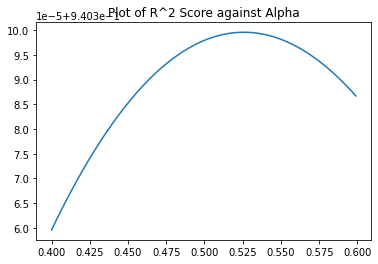

In [ ]:
alphas = np.arange(0.4, 0.6, 0.001)
scores = []
for a in alphas:
  reg = linear_model.Ridge(alpha=a)
  reg.fit(x_train, y_train)
  y_prediction = reg.predict(x_test)
  score = r2_score(y_test,y_prediction)
  scores.append(score)
fig, ax = plt.subplots()
ax.plot(alphas, scores)
plt.title("Plot of R^2 Score against Alpha")

From the graph, we find that R^2 peaks when alpha = .525. We can re-train the model to use .525 to get our most accurate prediction.

In [ ]:
reg = linear_model.Ridge(alpha=.525)
reg.fit(x_train, y_train)
y_prediction = reg.predict(x_test)
score = r2_score(y_test,y_prediction)
mse = mean_squared_error(y_test,y_prediction)
print("y predictions: ", y_prediction)
print("r^2 score: ", score)
print("mean squared error: ", mse)

y predictions:  [ 0.71638009  2.30032886  0.6736049  ...  2.80661197 -0.10623879
  1.90733533]
r^2 score:  0.9403995767737124
mean squared error:  0.18337756474261022


Using alpha = .525, we get our best r^2 score of 94.04% and mean squared error of .1834

# Conclusion
summarize ML results:

- Using ridge regression, we were able to predict changes in sea level by station with a high accuracy of 94.04%

what this means:

- rephrase this : "Predicting changes in sea level on the regional level is important because rise in sea level is a safety concern to those living close to the coast, can harm both land and sea ecosystems, and can destroy infrastructure"

future project ideas?? 



# Sources and Further Reading
About the data and related project:
*   About the index: https://actuariesclimateindex.org/about/
*   Data disclosure: https://actuariesclimateindex.org/data/data-disclosure/

Learn about rising sea levels globally:
*   https://www.climate.gov/news-features/understanding-climate/climate-change-global-sea-level

Data Tidying and Processing:
*   Basic Pandas Functionality: https://pandas.pydata.org/pandas-docs/stable/user_guide/basics.html
*   Dealing with null values: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html

Data Visualization:
*   Matlibplot tutorials: https://matplotlib.org/stable/tutorials/index.html
*   Seaborne heatmap: https://seaborn.pydata.org/generated/seaborn.heatmap.html

Machine Learning:
*   Scikit-learn tutorials: https://scikit-learn.org/stable/tutorial/index.html
*   Linear regression background: https://machinelearningmastery.com/linear-regression-for-machine-learning/
*   Ridge regression background and tutorial: https://www.mygreatlearning.com/blog/what-is-ridge-regression/
